# Do Restaurants in Ethnic Locations Get Marked for Health Violations More Often?

# Overview

In this analysis, I set out to discover whether or not restaurants with higher non-white populations receive more critical and noncritical violations than areas with lower non-white populations. After cleaning the datasets and carrying out correlation analysis and linear regression analysis, I discover that there is little to no correlation between the amount of violations and the ethnic makeup of an area. However, there is a correlation between the amount of health inspections that a restaurant receives and the amount of non-white inhabitants in an area.

# Name & PID

- Name: Kenny Chen
- PID: A14853871

# Research Question

Do restaurants in North Carolina zip code areas with higher non-white populations have higher rates of critical and noncritical health violations during health inspections than areas with lower non-white populations?

## Background and Prior Work

Recent events in 2020 have highlighted the instutionalized racism in America. Institutionalized racism is farspread, most notably plagueing our police departments. But does it affect something seemingly unrelated, such as restaurant health inspections? I want this research project to determine whether or not such institutionalized racism exists in the health inspections department, and determine whether or not restaurants in areas of higher non-white populations receive more critical health violations than those in areas of lower non-white populations.

References (include links):
- 1)https://slate.com/human-interest/2014/06/ethnic-restaurants-and-food-poisoning-the-subtle-racism-of-saying-chinese-food-caused-your-stomachache.html
If consumers can be subtly racist towards ethnic restaurants, so can health inspectors. Certain health inspectors could be naturally biased against a Chinese or Indian restaurant.
- 2)https://www.sciencedirect.com/science/article/abs/pii/S0278431915000274
This article discusses that ethnic-operated restaurants not only have higher rates of health violations - they also have higher rates of inspection.

# Hypothesis


My hypothesis is that restaurants in areas with higher non-white populations will have a higher rate of critical health violations than those in areas of low non-white populations. Because of the institutionalized racism that is prevalent in our society, I believe that inspection workers will be naturally biased against non-white restaurants.

# Dataset(s)

The datasets I will be using are the following:

- Dataset Name: inspections.csv
- Link to the dataset: Included in data.zip
- Number of observations: 36

The data set includes a list of health inspections in North Carolina. They contain a zip code and the amount of critical and noncritical violations in each inspection.

- Dataset Name: zipcodes.csv
- Link to the dataset: Included in data.zip
- Number of observations: 8

The data set contains a list of North Carolina zip codes, as well as the percentage of inhabitants that are not of caucasian descent.

The inspections dataset contains the zip code, which can be linked with the zipcodes dataset which contains percent of non-white inhabitants. I can use these two datasets to find a correlation between health violations and locations with less caucasian residents.

# Setup

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Statmodels & patsy
import patsy
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')
# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
# Round decimals when displaying DataFrames
pd.set_option('precision', 2)


# Data Cleaning

Describe your data cleaning steps here.

In [2]:
#read in datasets
df_in = pd.read_csv('inspections.csv')
df_zip = pd.read_csv('zipcodes.csv')

#Drop uneeded columns
df_in = df_in.drop(labels=['name','date','address2','phonenumber','restaurantopendate','days_from_open_date','postalcode','x','y','geocodestatus','type','description','inspectedby','inspection_num','inspector_id','previous_inspection_date','days_since_previous_inspection','previous_inspection_by_same_inspector','num_critical_previous','num_non_critical_previous','num_critical_mean_previous','num_non_critical_mean_previous','avg_neighbor_num_critical','avg_neighbor_num_non_critical','top_match','second_match','critical','address1'], axis=1)
df_zip = df_zip.drop(labels=['median_family_income_dollars','median_household_income_dollars','per_capita_income_dollars','percent_damilies_below_poverty_line','percent_snap_benefits','percent_supplemental_security_income'], axis=1)

#rename some columns
df_in = df_in.rename(columns={'hsisid': 'ID', 'facilitytype': 'type', 'num_critical':'critical mistakes','num_non_critical':'noncritical mistakes'})
df_zip = df_zip.rename(columns={'percent_nonwhite':'ethnic percentage'})

#merge the two on zip
df = pd.merge(df_zip, df_in, on='zip')

#Drop non-restaurants, then drop type column
df = df[df['type'] == 'Restaurant']
df = df[df['state'] == 'NC']
df = df.drop(labels=['type','state'], axis=1)

#Create new column to represent the total sum of restaurants in the zip code that underwent checks
df['number of inspections'] = 1

#combine the number of critical mistakes and drop ID & city
df = df.groupby(['zip','ethnic percentage'],as_index=False).agg({'critical mistakes': 'sum', 'noncritical mistakes':'sum','score':'mean','number of inspections':'sum'})
#df.describe()

#Create a column for average critical & noncritical mistakes
df['average critical'] = df['critical mistakes']/df['number of inspections']
df['average noncritical'] = df['noncritical mistakes']/df['number of inspections']

#Sort by ethnic percentage
df = df.sort_values(by='ethnic percentage')
df

,zip,ethnic percentage,critical mistakes,noncritical mistakes,score,number of inspections,average critical,average noncritical
26,27608,8.7,349,728,95.56,122,2.86,5.97
14,27562,13.6,34,37,95.28,9,3.78,4.11
18,27592,14.6,27,74,92.71,7,3.86,10.57
...,...,...,...,...,...,...,...,...
13,27560,53.3,2315,2948,95.18,582,3.98,5.07
20,27601,69.9,1570,2321,95.87,541,2.90,4.29
28,27610,72.7,1295,2438,95.31,399,3.25,6.11


When presented with the datasets, inspections was filled with information, most of which was useless for my analysis. Zip also had a lot of irrelevant information, so I needed to do a bunch of cleaning.

The first thing I did was drop all the uneeded columns, since there were plenty of those. It would be a nightmare sorting through all 36 columns of inspections.

Then, I did some light renaming to make the titles more clear and easier to read.

After that, I merged the two datasets on 'zip', so that we could clearly see zip code, ethnic percentage, and the amount of mistakes side by side. I then dropped everything that was not a restaurant from the type column, and everything that was not in North Carolina. Those columns were then dropped for simplicity.

I then created a new column representing the number of restaurants so that we could see the number of mistakes as an average, and not as a big number (since more restaurants = more failures logically).

After that, I grouped the rows together based on zip code and created the average columns for critical and noncritical mistakes. 

Finally, I sorted the columns based on ethnic percentage, since that is our independent variable for this analysis.

The data is very clean, since I dropped all the columns that weren't needed in my analysis. Everything is easy to look at, and you can see all the relevant data side by side.

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

Correlation Matrix

[[ 1.       -0.101778]
 [-0.101778  1.      ]]


                            OLS Regression Results                            
Dep. Variable:                   crit   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.3454
Date:                Tue, 09 Jun 2020   Prob (F-statistic):              0.561
Time:                        16:40:01   Log-Likelihood:                -46.080
No. Observations:                  35   AIC:                             96.16
Df Residuals:                      33   BIC:                             99.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

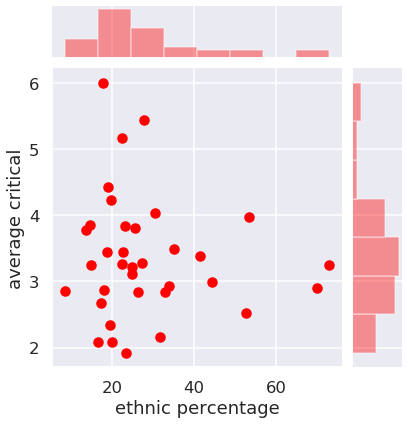

In [3]:
#Create a new df to use linear regression on
df_regress  = df.rename(columns={'ethnic percentage':'eth', 'average critical':'crit', 'average noncritical':'noncrit', 'number of inspections':'num'})

#Ethnic percentage and average crit in a scatterplot
sns.jointplot(x="ethnic percentage", y="average critical", data=df, kind = 'scatter', color = 'red')

#Correlation Matrix 
r = np.corrcoef(df['ethnic percentage'], df['average critical'])
print("Correlation Matrix\n")
print(r)
print("\n")

#Linear Regression 
outcome, predictors = patsy.dmatrices('crit ~ eth', df_regress)
mod = sm.OLS(outcome, predictors)
## fit the model
res = mod.fit()
## look at the results
print(res.summary())

### EDA:
Because I am finding the relationship between two variables, my variables take the form of a bivariate distribution. The easiest form of visualization when comparing these two variables is a scatterplot.

As you can see from the scatterplot, there does not seem to be any positive correlation between the ethnic percentage and the average amount of critical mistakes. In fact, there appears to be a slight negative correlation.

There are not really any clear outliers, since there does appear to be a slight downward trend. All the points generally follow this, even the highest point at 6 average failures.

### Correlation Analysis:
I chose to do correlation analysis, since I am trying to find out the correlation between two variables.

The correlation matrix returns a matrix, where the two values of importance are the correlation between our independent and dependent variable, which is -0.101778.

The correlation confirms that there is indeed a slight negative correlation between the ethnic percentage and average critical mistakes. However, it is relatively small at -.1, so it is negligible.

### Linear Regression Analysis:
I chose to do linear regression to see if it was possible for me to predict average critical failures from the ethnic percentage. 

The OLS Linear regression model returns a P-value of .561. As such, we have failed to reject our null hypothesis, and our results are not statistically significant. There is most likely no way to accurately predict the amount of average critical failures from the ethnic percentage in an area.

Correlation Matrix

[[ 1.         -0.08219182]
 [-0.08219182  1.        ]]


                            OLS Regression Results                            
Dep. Variable:                noncrit   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.2244
Date:                Tue, 09 Jun 2020   Prob (F-statistic):              0.639
Time:                        16:40:03   Log-Likelihood:                -57.433
No. Observations:                  35   AIC:                             118.9
Df Residuals:                      33   BIC:                             122.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

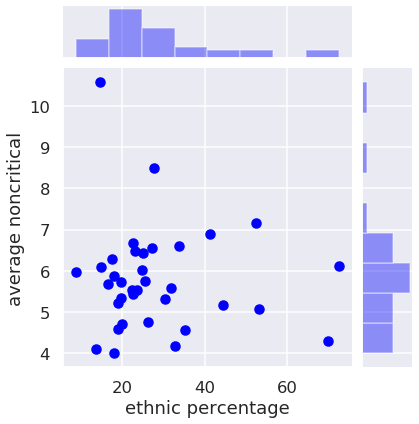

In [4]:
#Ethnic percentage and average noncrit in a scatterplot
sns.jointplot(x="ethnic percentage", y="average noncritical", data=df,kind = 'scatter', color = 'blue');

#Correlation Matrix 
r = np.corrcoef(df['ethnic percentage'], df['average noncritical'])
print("Correlation Matrix\n")
print(r)
print("\n")

#Linear Regression 
outcome, predictors = patsy.dmatrices('noncrit ~ eth', df_regress)
mod = sm.OLS(outcome, predictors)
## fit the model
res = mod.fit()
## look at the results
print(res.summary())

### EDA:
Because I am finding the relationship between two variables, my variables take the form of a bivariate distribution. The easiest form of visualization when comparing these two variables is a scatterplot.

Purely from eyeballing the scatterplot, there appears to be some sort of positive correlation. However, it appears to incredibly minute and negligible.

There are two notable outliers that could skew the average data tremendously. One of them is at around 10.6 average noncritical failures, and another is at around 8.5. Both are far from the increasing upward slope of ethnic percentage to noncritical failures.

### Correlation Analysis:
I chose to do correlation analysis, since I am trying to find out the correlation between two variables.

The correlation matrix returns a matrix, where the two values of importance are the correlation between our independent and dependent variable, which is -0.08219182.

The correlation claims that there is a slight negative correlation between our two variables. However, this is most likely due to the outliers as mentioned earlier. Nonetheless, -.08 is small, and definitely negligible.

### Linear Regression Analysis:
I chose to do linear regression to see if it was possible for me to predict average critical failures from the ethnic percentage. 

The OLS Linear regression model returns a P-value of .639. As such, we have once again failed to reject our null hypothesis, and our results are not statistically significant. There is most likely no way to accurately predict the amount of average noncritical failures from the ethnic percentage in an area.

Correlation Matrix

[[1.         0.33479207]
 [0.33479207 1.        ]]


                            OLS Regression Results                            
Dep. Variable:                    num   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.166
Date:                Tue, 09 Jun 2020   Prob (F-statistic):             0.0493
Time:                        16:40:04   Log-Likelihood:                -237.96
No. Observations:                  35   AIC:                             479.9
Df Residuals:                      33   BIC:                             483.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

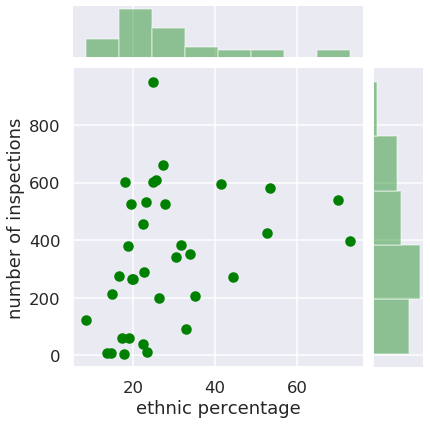

In [5]:
#Ethnic percentage and number of restaurants in a scatterplot
sns.jointplot(x="ethnic percentage", y="number of inspections", data=df,kind = 'scatter', color = 'green');

#Correlation Matrix 
r = np.corrcoef(df['ethnic percentage'], df['number of inspections'])
print("Correlation Matrix\n")
print(r)
print("\n")

#Linear Regression 
outcome, predictors = patsy.dmatrices('num ~ eth', df_regress)
mod = sm.OLS(outcome, predictors)
## fit the model
res = mod.fit()
## look at the results
print(res.summary())

### EDA:
At a dead end between finding the correlation between ethnic percentage and mistakes, I chose instead to also test the correlation between ethnic percentage and the number of restaurants that are being inspected.

Because I am finding the relationship between two variables, my variables take the form of a bivariate distribution. The easiest form of visualization when comparing these two variables is a scatterplot.

As you can see from the scatterplot, there does seem to be a positive correlation between the ethnic percentage and the number of restaurants that received health inspections. Areas with low ethnic percentage received significantly less inspections than areas with higher ethnic percentage.

There is one notable outlier, marked at almost 1000 restaurants inspected. Perhaps this is in an area with high restaurant density.

### Correlation Analysis:
I chose to do correlation analysis, since I am trying to find out the correlation between two variables.

The correlation matrix returns a matrix, where the two values of importance are the correlation between our independent and dependent variable, which is 0.33479207.

The correlation confirms that there is a positive correlation between ethnic percentage and the number of restaurants that receive health inspections. That is, if an area has a higher ethnic population, then the restaurants there are more likely to be inspected for health problems.

### Linear Regression Analysis:
I chose to do linear regression to see if it was possible for me to predict average critical failures from the ethnic percentage. 

The OLS Linear regression model returns a P-value of .049. If we assume an alpha of .05, that means we reject our null hypothesis that there is no correlation between ethnic percentage and the number of restaurants that receieve health inspections. 

# Ethics & Privacy

There are a few privacy concerns relating to my analysis. 

The first one that came to mind was that restaurants and restaurant owners may not want their health inspection history to be made available to the public. In addition to this, health inspectors may not want their inspection history to be known, especially if they have a history of giving certain types of restaurants more critical failures than others (or any type of personal bias). To solve this, I made sure to remove any and all restaurant and human names from my analysis, only keeping numbers that were absolutely crucial. 

Another concern was whether I had permission to use this data. Considering this was information is official government information from the state of North Carolina, I assume that this information is available for public use.

I do not have to worry about biases in the data I used, since it is official documentation and consists solely of government records and government information about the demographics of certain cities and locations.

# Conclusion & Discussion

The question I sought to answer with my analysis was whether or not areas with higher non-white populations received more critical and noncritical health mistakes during health inspections in North Carolina.

After carrying out my analysis and testing for correlation, I concluded that there was virtually no correlation between the average amount of mistakes and the amount of ethnic residents in an area, disproving my initial hypothesis. 

However, I did find that ethnic population percentage was correlated to the number of restaurants that received health inspections, which may be evidence of institutionalized racism since it brings up the question: do health inspectors specifically target ethnic restaurants for health inspections because of personal biases against certain ethnicities?  